<a href="https://colab.research.google.com/github/ubern-mia/bme-labs/blob/main/Session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 2
This notebook gives you a starting point for the second session, where we try to automatically classify if a patient has a disease from the FastSurfer outputs.

After uploading, we start with a brief data exploration part.

In [1]:
from google.colab import files
! cd "/content"
uploaded = files.upload()

measurements = "/content/" + list(uploaded.keys())[0]

Saving fsfaststats.csv to fsfaststats.csv


The upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# define a mapping of the disease encoding back to strings
diseasestatus = {0: "Healthy", 1: "ASD", 2: "Epilepsy"}

measurements = pd.read_csv("/content/fsfaststats.csv")

# map the disease name to the encoding and make sure the age is a float
measurements["Disease"] = [diseasestatus[e] for e in measurements["Disease"]]
measurements["Age"] = [float(e) for e in measurements["Age"]]

plotcols = list(set(measurements.columns) - set(["Age", "Subject", "Disease"]))

Let's plot it! The example limits it to the first five columns.

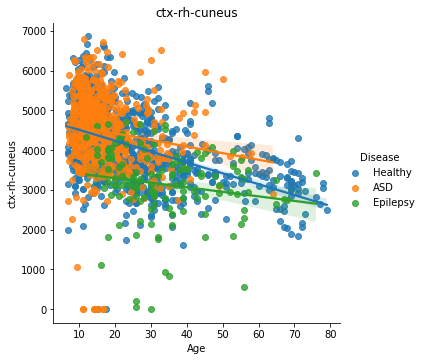

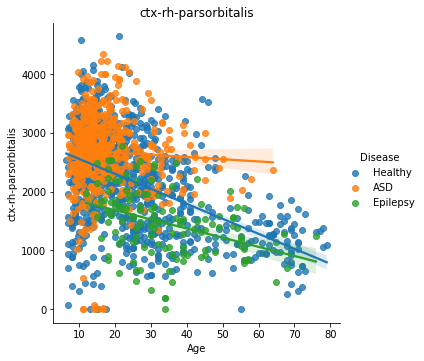

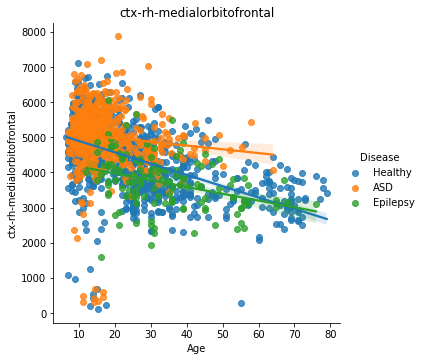

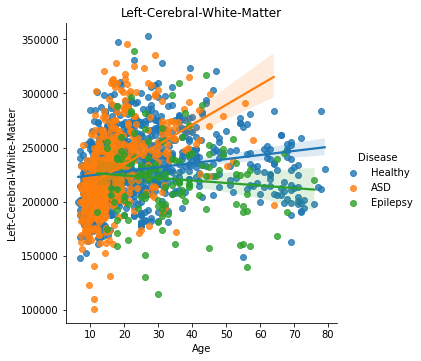

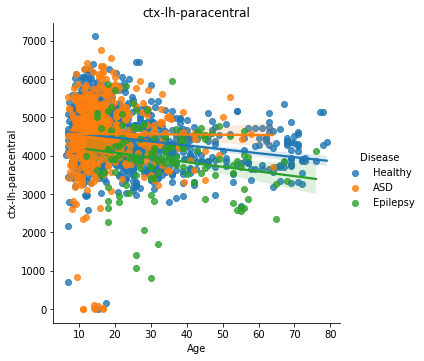

In [3]:
for col in plotcols[:5]:
    ax = sns.lmplot(x="Age", y=col, hue="Disease", data=measurements, ci=95)
    ax.fig.subplots_adjust(top=.95)
    plt.title(col)
    plt.show()

As you can probably see, it is hard to see relevant difference here. Let's see what we can achieve by feeding the data into common machine learning models.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score

# this is how you create your custom scorer, e.g., using the balanced accuracy.
# you can use any metric from sklearn that way, but you have to import it like
# it is done above
# (list here:https://scikit-learn.org/stable/modules/model_evaluation.html)
balanced_scorer = make_scorer(balanced_accuracy_score)

# X is the feature matrix we feed to the classifier, i.e. the measurements and the age of the subject
features = list(set(measurements.columns) - set(["Subject", "Disease"]))
X = measurements.loc[:, features]
y = measurements["Disease"]

# Reserve 20% of the data for testing
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
  print("Training set size: " + str(len(train_index)))
  print("Test set size: " + str(len(test_index)))

X_train = X.iloc[train_index, :]
y_train = y.iloc[train_index]

X_test = X.iloc[test_index, :]
y_test = y.iloc[test_index]

# Let's first try a Random Forest classifier
crossval = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)

# use the default scorer (accuracy)
scores = cross_val_score(clf, X_train, y_train, cv=crossval)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# we can also use our own scorer (with the balanced accuracy)
scores_bal = cross_val_score(clf, X_train, y_train, cv=crossval, scoring=balanced_scorer)
print("%0.2f bal. accuracy with a standard deviation of %0.2f" % (scores_bal.mean(), scores_bal.std()))


Training set size: 1308
Test set size: 328
0.67 accuracy with a standard deviation of 0.02
0.56 bal. accuracy with a standard deviation of 0.05


Let's apply it to the test set and see how it goes

              precision    recall  f1-score   support

     Healthy       0.62      0.39      0.48       107
         ASD       0.82      0.36      0.50        25
    Epilepsy       0.67      0.86      0.76       196

    accuracy                           0.67       328
   macro avg       0.70      0.54      0.58       328
weighted avg       0.67      0.67      0.65       328



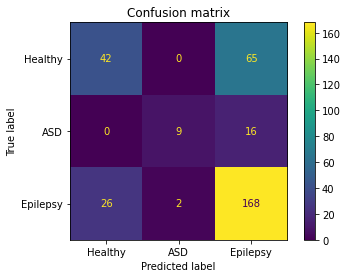

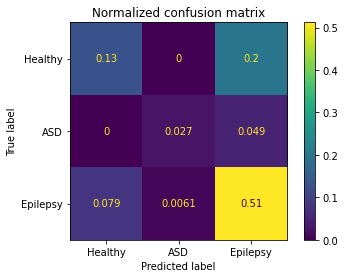

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Train a Random Forest and apply it to the test set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=None,
                                        display_labels=diseasestatus.values(), 
                                        include_values=True, 
                                        xticks_rotation='horizontal', 
                                        values_format=None, cmap='viridis', 
                                        colorbar=True)
plt.title("Confusion matrix")
plt.show()

# And another normalized version
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=None, 
                                        normalize='all', 
                                        display_labels=diseasestatus.values(), 
                                        include_values=True, 
                                        xticks_rotation='horizontal', 
                                        values_format=None, cmap='viridis', 
                                        ax=None, colorbar=True)
plt.title("Normalized confusion matrix")
plt.show()

